# Generative Adversarial Networks (GANs)

A generative adversarial network (GAN) is a machine learning (ML) model in which two neural networks compete with each other to become more accurate in their predictions. GANs typically run unsupervised and use a cooperative zero-sum game framework to learn.

The two neural networks that make up a GAN are referred to as the generator and the discriminator. The goal of the generator is to artificially manufacture outputs that could easily be mistaken for real data. The goal of the discriminator is to identify which outputs it receives have been artificially created.

## About

To generate handwritten digits using GAN. 

[MNIST](http://yann.lecun.com/exdb/mnist/) dataset is used here.

## Requirements
I used Google Colab with GPU support for this project. However, if you want to run this offline you'll need the following:

* Python 3
* Tensorflow 2.0
* Numpy
* Matplotlib
* Scikit-Image




## Necessary Imports

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from skimage.io import imread
import matplotlib.pyplot as plt
import sys, os
%matplotlib inline

## Loading & Pre-Processing the Dataset

Load and split the dataset into train and test variables

In [0]:
MNIST = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = MNIST.load_data()

## Standardizing and Scaling

Standardize the training and testing data to follow standard normal distribution and scale the values between -1 to +1

In [0]:
X_train = X_train / 255.0 * 2 - 1
X_test = X_test / 255.0 * 2 - 1

Reshape train and test variables to required shape

In [6]:
print(X_train.shape)

(60000, 28, 28)


In [0]:
N, H, W = X_train.shape
D = H * W

In [0]:
x_train = X_train.reshape(-1, D)
x_test = X_test.reshape(-1, D)

Latent space dimension

In [0]:
latent_dim = 100

## Building the Generator

The generator is the Neural Network model that will generate the fake image which when input with noise

In [0]:
def init_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)

  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)

  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)

  x = Dense(D, activation='tanh')(x)

  model = Model(inputs=i, outputs=x)

  return model

## Building the Discriminator

The discriminator is the Neural Network model that acts as a binary classifier which is going to help our generator to generate photorealistic images

In [0]:
def init_discriminator(img_size):
  i = Input(shape=(img_size,))

  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)

  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)

  x = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=i, outputs=x)

  return model

## Building the Combined model (Adversarial)

The combined model is nothing but the adversarial model where the discriminator and generator are going to be adversarial which after proper training can be used to generate photrealistic images and even used to predict fake images

In [0]:
# instantiate the discriminator
discriminator = init_discriminator(D)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# instatiate the generator
generator = init_generator(latent_dim)

# input layer of combined model
z = Input(shape=(latent_dim,))

# input the noise to the generator to generate an image
img = generator(z)

# freeze discriminator weights
discriminator.trainable = False

fake_prediction = discriminator(img)

# Create and compile the combined model
combined_model = Model(inputs=z, outputs=fake_prediction)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

## Utility function

To save the images after regular intervals.

In [0]:
def save_images(epoch):
  if not os.path.exists('/content/drive/My Drive/GAN_images'):
    os.makedirs('/content/drive/My Drive/GAN_images')

  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1

  fig.savefig("/content/drive/My Drive/GAN_images/%d.png" % epoch)
  plt.close()

## Train the GAN

Train our GAN model for 50000 epochs and save the generated images at specified intervals

In [0]:
# batch size, epochs and interval to save images
BATCH_SIZE = 32
EPOCHS = 50000 
sample_period = 500 

In [0]:
# generate 0's and 1's for real and fake labels
ones = np.ones(BATCH_SIZE)
zeros = np.zeros(BATCH_SIZE)

In [0]:
# empty lists to store the generator and discriminator's loss
d_losses = []
g_losses = []

In [17]:
for epoch in range(EPOCHS):
  # random selection of images as a batch
  idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
  real_imgs = x_train[idx]
  
  # generate fake images
  noise = np.random.randn(BATCH_SIZE, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # train the discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  # train the generator
  noise = np.random.randn(BATCH_SIZE, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  noise = np.random.randn(BATCH_SIZE, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # save the discriminator and generator's losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  # print the training metrics
  if epoch % 100 == 0 and epoch!=0:
    print("Epoch {}\nDiscriminator Loss {:.2f} Accuracy {:.2f} | Generator Loss {:.2f}".format((epoch), d_loss, d_acc, g_loss))

  if epoch==49999 or epoch==0:
    print("Epoch {}\nDiscriminator Loss {:.2f} Accuracy {:.2f} | Generator Loss {:.2f}".format((epoch+1), d_loss, d_acc, g_loss))  

  # save the generated images at given training intervals
  if epoch % sample_period == 0:
    save_images(epoch)

Epoch 1
Discriminator Loss 0.95 Accuracy 0.45 | Generator Loss 0.89
Epoch 100
Discriminator Loss 0.03 Accuracy 1.00 | Generator Loss 3.53
Epoch 200
Discriminator Loss 0.85 Accuracy 0.42 | Generator Loss 0.69
Epoch 300
Discriminator Loss 0.72 Accuracy 0.38 | Generator Loss 0.60
Epoch 400
Discriminator Loss 0.70 Accuracy 0.50 | Generator Loss 0.61
Epoch 500
Discriminator Loss 0.69 Accuracy 0.48 | Generator Loss 0.64
Epoch 600
Discriminator Loss 0.69 Accuracy 0.44 | Generator Loss 0.66
Epoch 700
Discriminator Loss 0.68 Accuracy 0.53 | Generator Loss 0.68
Epoch 800
Discriminator Loss 0.65 Accuracy 0.67 | Generator Loss 0.73
Epoch 900
Discriminator Loss 0.70 Accuracy 0.50 | Generator Loss 0.75
Epoch 1000
Discriminator Loss 0.63 Accuracy 0.66 | Generator Loss 0.74
Epoch 1100
Discriminator Loss 0.66 Accuracy 0.67 | Generator Loss 0.78
Epoch 1200
Discriminator Loss 0.61 Accuracy 0.69 | Generator Loss 0.81
Epoch 1300
Discriminator Loss 0.63 Accuracy 0.66 | Generator Loss 0.86
Epoch 1400
Discrim

## Visualizing the GAN's loss

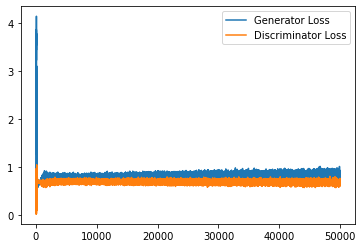

In [18]:
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()

## Visualizing the images generated by our GAN

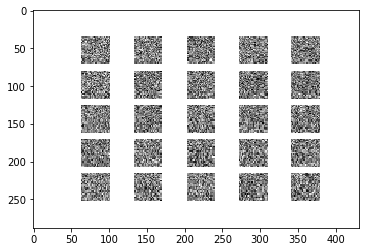

In [19]:
gi = imread('/content/drive/My Drive/GAN_images/0.png')
plt.imshow(gi, cmap='Greys')

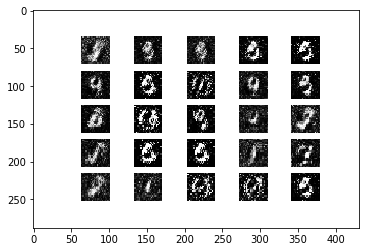

In [20]:
gi = imread('/content/drive/My Drive/GAN_images/1000.png')
plt.imshow(gi, cmap='Greys')

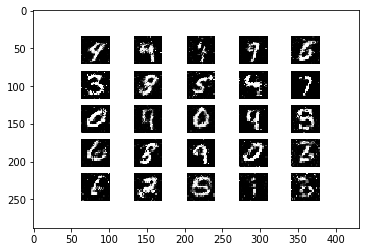

In [21]:
gi = imread('/content/drive/My Drive/GAN_images/5000.png')
plt.imshow(gi, cmap='Greys')

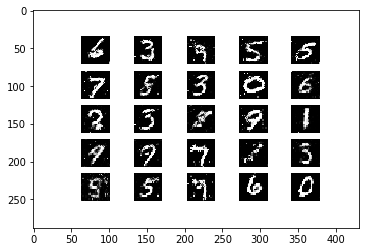

In [22]:
gi = imread('/content/drive/My Drive/GAN_images/10000.png')
plt.imshow(gi, cmap='Greys')

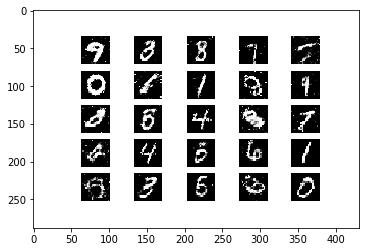

In [23]:
gi = imread('/content/drive/My Drive/GAN_images/25000.png')
plt.imshow(gi, cmap='Greys')

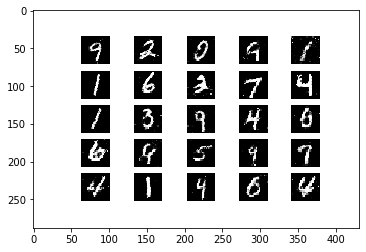

In [24]:
gi = imread('/content/drive/My Drive/GAN_images/40000.png')
plt.imshow(gi, cmap='Greys')

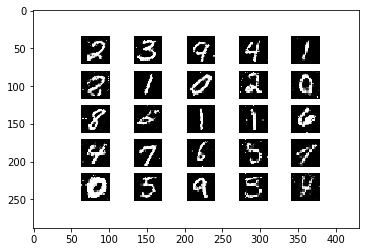

In [25]:
gi = imread('/content/drive/My Drive/GAN_images/49500.png')
plt.imshow(gi, cmap='Greys')

## Save the GAN model

In [0]:
combined_model.save_weights('/content/drive/My Drive/Colab Notebooks/models/GAN_combined_model.h5')
discriminator.save_weights('/content/drive/My Drive/Colab Notebooks/models/GAN_discriminator.h5')
generator.save_weights('/content/drive/My Drive/Colab Notebooks/models/GAN_generator.h5')